**Install Dependencies**

In [1]:
# %%capture
# !pip install -U torch torchvision torchaudio torcheval
# !pip install -U triton xformers
# !pip install -U diffusers transformers accelerate jupyter huggingface-hub bitsandbytes tqdm;
# !pip install -U cjm_pil_utils cjm_pytorch_utils cjm_diffusers_utils

**Check diffusers version**

In [2]:
# Import the `diffusers` module
import diffusers

# Print the version number of the `diffusers` module
print(diffusers.__version__)

0.12.1


**Import Dependencies**

In [3]:
# Import necessary modules from the standard library
from pathlib import Path  # For working with file paths
import hashlib  # For generating hash values
import json  # For working with JSON data
import random  # For generating random numbers
import math

from PIL import Image  # For working with images

import numpy as np  # For working with arrays

import torch  # PyTorch module for deep learning
from torchvision import transforms  # PyTorch module for image transformations

# Import diffusers pipeline and noise schedulers
from diffusers import StableDiffusionPipeline
from diffusers import DEISMultistepScheduler

# Import tqdm module for progress bars
from tqdm.auto import tqdm

import pandas as pd
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

In [4]:
from cjm_diffusers_utils.core import *
from cjm_pil_utils.core import stack_imgs, get_img_files
from cjm_pytorch_utils.core import get_torch_device

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [5]:
# Import the notebook_login function from the huggingface_hub module
from huggingface_hub import notebook_login

# If the user does not have a an access token saved, prompt them to log in
if not (Path.home()/'.huggingface'/'token').exists():
    notebook_login()

**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML Open RAIL++-M License](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* [**Stable Diffusion v2-1 Base Model Card**](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [**Stable Diffusion v2-1 Model Card**](https://huggingface.co/stabilityai/stable-diffusion-2-1)

**Select a model**

In [6]:
# model_name = "stabilityai/stable-diffusion-2-1-base"
model_name = "stabilityai/stable-diffusion-2-1"

In [7]:
# model_name = 'dreambooth_checkpoints/cp2077-steelbook-768-tyger_claws'

**Set device and data type**

In [8]:
device = get_torch_device()
dtype = torch.float16 if device == 'cuda' else torch.float32
device, dtype

('cuda', torch.float16)

**Define a Stable Diffusion Image-to-Image pipeline**

In [9]:
pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=dtype).to(device)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

/home/innom-dt/mambaforge/envs/sd-testing/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [10]:
unet = pipe.unet
vae = pipe.vae

In [11]:
# Try to use xFormers for memory efficient attention
try:
    unet.enable_xformers_memory_efficient_attention()

# If an exception is raised, print a message indicating that it was unable to use the xformers
except:
    print("Unable to use xformers.")

In [12]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

**Define directory to store generated images**

In [13]:
output_dir = Path("./output_dir/text2img/")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

PosixPath('output_dir/text2img')

**Define path to dataset**

In [14]:
# dataset_path = Path(f"/mnt/980_1TB_2/Datasets/pexels-110k-512p-min-jpg/")
dataset_path = Path(f"/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/")

In [15]:
# Set the file path for the attributes dataframe
attributes_df_json_file = Path(dataset_path/'attributes_df.json')

# Print the file path
print(attributes_df_json_file)

/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/attributes_df.json


**Import image attributes**

In [16]:
# Read the attributes dataframe from the JSON file
attributes_df = pd.read_json(attributes_df_json_file)

# Print the number of entries in the dataframe
print(f"Number of entries: {len(attributes_df)}")

# Display the first few rows of the dataframe
attributes_df.head().transpose()

Number of entries: 109971


,3186010,3185509,3182800,3184308,3185747
title,Pink and White Ice Cream Neon Signage,Garnishing of Syrup on a Cheesecake,People in Front of the Computers,Photo Of People Next To Each Other,Aerial View of Coconut Trees at Rural Area
aspect_ratio,0.749809,1.0,1.498501,1.5,1.499795
main_color,"[128, 38, 77]","[185, 167, 164]","[176, 175, 169]","[201, 179, 150]","[154, 139, 128]"
colors,"[#000000, #a52a2a, #bc8f8f, #c71585, #d02090, #d8bfd8]","[#000000, #696969, #bc8f8f, #cd5c5c, #d3d3d3]","[#000000, #696969, #a9a9a9, #add8e6, #f5f5f5]","[#708090, #a0522d, #cd853f, #eedd82, #ffdab9]","[#696969, #808080]"
tags,"[bright, chocolate, close-up, cold, cream, creamy, cup, dairy product, delicious, design, dessert, electricity, epicure, flavors, fluorescent, food, food photography, goody, hand, ice cream, icecream, illuminated, indulgence, light pink background, neon, neon lights, neon sign, pastry, pink background, pink wallpaper, scoop, sweet, sweets, tasty]","[cheesecake, dessert, epicure, food photography, food plating, food porn, food preparation, food styling, garnishing, gastronomy, glaze, syrup]","[colleagues, computer, connection, cooperation, desk, dreadlocks, employees, facial expression, furniture, indoors, internet, looking, office, people, room, sit, sitting, table, teamwork, technology, women, work, working, workplace]","[adults, casual, communication, conversation, fashion, fashionable, fun, gather, gathered, gathering, happiness, happy, leisure, outfit, recreation, sit, sitting, smile, smiling, style, stylish, wear]","[aerial shot, coconut trees, daylight, drone shot, exotic, high angle shot, outdoors, palm trees, sand, summer, trees, tropical]"
adult,very_unlikely,very_unlikely,unlikely,unlikely,None
aperture,1.8,NaN,NaN,NaN,2.6
camera,iPhone X,,None,None,FC1102
focal_length,4.0,NaN,NaN,NaN,4.49
google_place_id,ChIJkUjxJ7it1y0R4qOVTbWHlR4,None,None,None,None


In [17]:
# Set the path for the images directory
img_dir = Path(dataset_path/"images/")

In [18]:
# Get a list of the paths to the images in the images directory
img_paths = get_img_files(img_dir)

# Print the number of images in the images directory
print(len(img_paths))

109971


In [19]:
# Create a dictionary mapping image IDs to image paths
img_path_dict = {int(path.stem.split('-')[-1]) : path for path in img_paths}

# Display the first few entries in the dictionary using a Pandas Dataframe
pd.DataFrame.from_dict(img_path_dict, orient='index').head()

,0
1061142,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-art-background-1061142.jpg
2586334,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-person-beauty-face-blurred-background-2586334.jpg
1460032,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/1-wtc-artist-concert-1460032.jpg
1061133,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/10-art-artistic-1061133.jpg
1339845,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/10-art-color-1339845.jpg


**Store list of image IDs**

In [20]:
img_ids = attributes_df.index.to_list()

**Load list of image IDs if present**

In [21]:
img_ids_path = Path(f"{model_name}/img_ids.txt")

if img_ids_path.exists():
    with open(img_ids_path, "r") as read_file:
        img_ids = read_file.readlines()
    img_ids = [int(img_id.removesuffix("\n")) for img_id in img_ids]
    print(len(img_ids))

**Create a prompt dictionary**

In [22]:
# Define a function that constructs the prompts using the 'title' and 'tags' columns
def construct_prompt(row):
    # Check if the 'tags' column is not None
    if row['tags'] is not None:
        # If the 'tags' column is not None, return a string that combines the 'title' and 'tags' columns
        return f"{row['title']}, {', '.join(row['tags'])}"
    else:
        # If the 'tags' column is None, return the 'title' column
        return row['title']

# Apply the 'construct_prompt' function to each row of the DataFrame
# and store the result in a dictionary with keys as image IDs
prompt_dict = attributes_df.apply(construct_prompt, axis=1).to_dict()

**Define method to save image with unique file name**

In [23]:
def save_img(image, save_dir, fmt='PNG'):
    # Calculate the SHA256 hash of the image
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]

    # Save the image to the specified directory with the hash as the file name
    image.save(f"{save_dir}/{img_hash}.{fmt.lower()}", format=fmt)

    # Return the image hash
    return img_hash

**Define method to pipeline config used to generate an image**

In [24]:
def save_pipe_config(img_name, pipe_config, save_dir):
    # Save the pipe configuration to a JSON file with the given image name
    with open(f"{save_dir}/{img_name}.json", "w") as write_file:
        json.dump(pipe_config, write_file)

In [25]:
def denoise_text2img(latents, text_emb, unet, noise_scheduler, guidance_scale=8.0):
        
    """
    Generate an image from a given prompt.
    
    Parameters:
    """
    
    # Denoising loop
    for i,ts in enumerate(tqdm(noise_scheduler.timesteps)):
        
        # Scale latents
        inp = noise_scheduler.scale_model_input(torch.cat([latents] * 2), ts)
              
        # Get model output
        with torch.no_grad(): 
            noise_pred_uncond, noise_pred_text = unet(inp, ts, encoder_hidden_states=text_emb).sample.chunk(2)
        
        g_current = guidance_scale
        
        # Apply guidance
        noise_pred = noise_pred_uncond + g_current*(noise_pred_text-noise_pred_uncond)
        
        # Update latents
        latents = noise_scheduler.step(noise_pred, ts, latents).prev_sample
        
        # Releases all unoccupied cached memory
        if unet.device.type == 'cuda': torch.cuda.empty_cache()
    
    return latents

**Inspect a sample image**

ID: 920331
Title: Photo of Golden Gate Bridge
Tags: architecture, bridge, city, clouds, connection, daylight, forest, iron, sky, steel, transportation system, travel, trees, woods


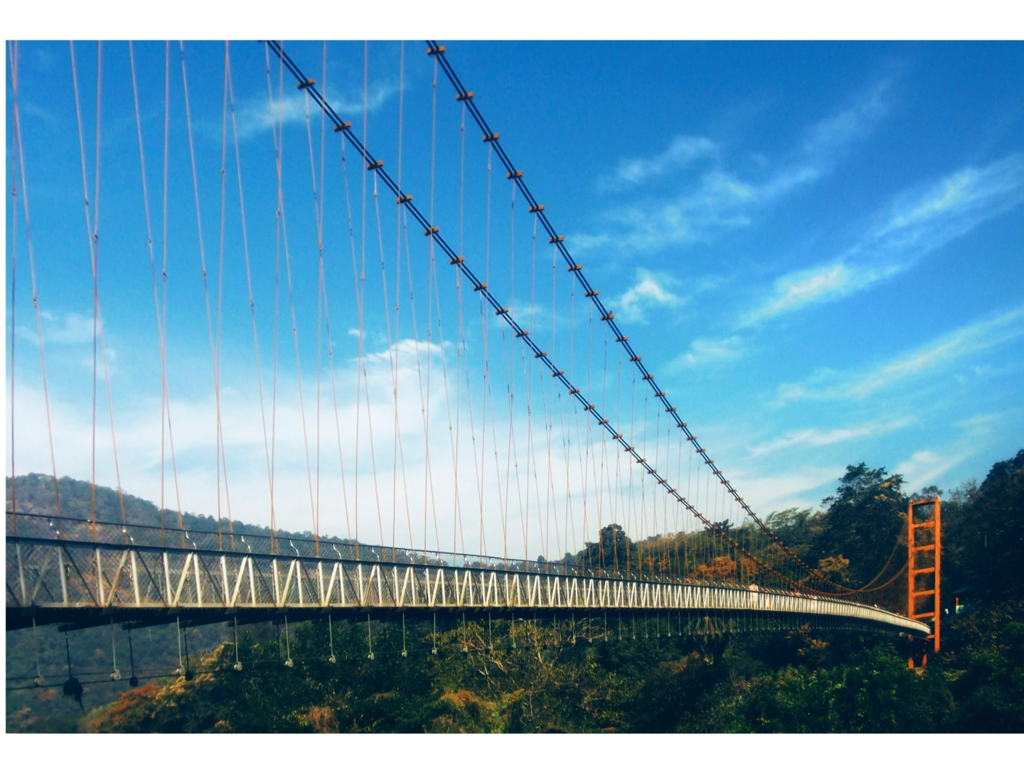

In [26]:
# Choose a random image ID from the list of image IDs
img_id = random.choice(img_ids)

print(f"ID: {img_id}")

# Open the image located at the path in the img_path_dict with the key of the current img_id
img_path = img_path_dict[img_id]
sample_img = Image.open(img_path)

# Print the title of the image, located in the 'title' column of the attributes_df dataframe
print(f"Title: {attributes_df.loc[img_id]['title']}")

# Print the title of the image, located in the 'title' column of the attributes_df dataframe
if attributes_df.loc[img_id]['tags'] is not None:
    print(f"Tags: {', '.join(attributes_df.loc[img_id]['tags'])}")

# Display the image
sample_img

In [27]:
# src_prompt = prompt_dict[img_id]|
src_prompt = attributes_df.loc[img_id]['title']
# src_prompt = f"{img_id} {attributes_df.loc[img_id]['title']}"
src_prompt

'Photo of Golden Gate Bridge'

In [28]:
new_token = None
if len(tokenizer.added_tokens_encoder.keys()) > 0:
    new_token = list(tokenizer.added_tokens_encoder.keys())[0]
new_token

In [29]:
# style_weight = math.ceil(len(tokenizer.tokenize(src_prompt))//2)
style_weight = 1

In [30]:
style_prompt = ', '.join([f'monet oil painting']*(style_weight))
# style_prompt = ', '.join([f'{new_token} style']*(style_weight))

In [31]:
prompt = f"{style_prompt}, {src_prompt}"
prompt

'monet oil painting, Photo of Golden Gate Bridge'

In [32]:
# prompt = src_prompt

**Define negative prompt**

In [33]:
negative_prompt = "bad, deformed, ugly, bad anotomy"
# negative_prompt = ""
negative_prompt

'bad, deformed, ugly, bad anotomy'

**Initialize random number generator for consistent images**

In [34]:
generator = torch.Generator(device=device)
generator.manual_seed(789890158);

In [35]:
infer_scheduler = DEISMultistepScheduler.from_pretrained(model_name, subfolder="scheduler")
# infer_scheduler = pipe.scheduler

In [36]:
sample_img.size

(1024, 768)

In [37]:
pipe_config = {}
# pipe_config['pipeline'] = pipe.config['_class_name']
pipe_config['model'] = model_name
pipe_config['prompt'] = prompt
pipe_config['negative_prompt'] = negative_prompt
pipe_config['init_img'] = str(img_path)
pipe_config['height'] = sample_img.height
pipe_config['width'] = sample_img.width
pipe_config['strength'] = 0.7
pipe_config['steps'] = 25
pipe_config['guidance'] = 8.0
pipe_config['init_seed'] = generator.initial_seed()
pipe_config['generator_state'] = [int(i) for i in generator.get_state()]
pipe_config['eta'] = 0.0
pd.DataFrame.from_dict(pipe_config, orient='index')

,0
model,stabilityai/stable-diffusion-2-1
prompt,"monet oil painting, Photo of Golden Gate Bridge"
negative_prompt,"bad, deformed, ugly, bad anotomy"
init_img,/mnt/980_1TB_2/Datasets/pexels-110k-768p-min-jpg/images/mobilechallenge-architecture-bridge-920331.jpg
height,768
width,1024
strength,0.7
steps,25
guidance,8.0
init_seed,789890158


  0%|          | 0/17 [00:00<?, ?it/s]

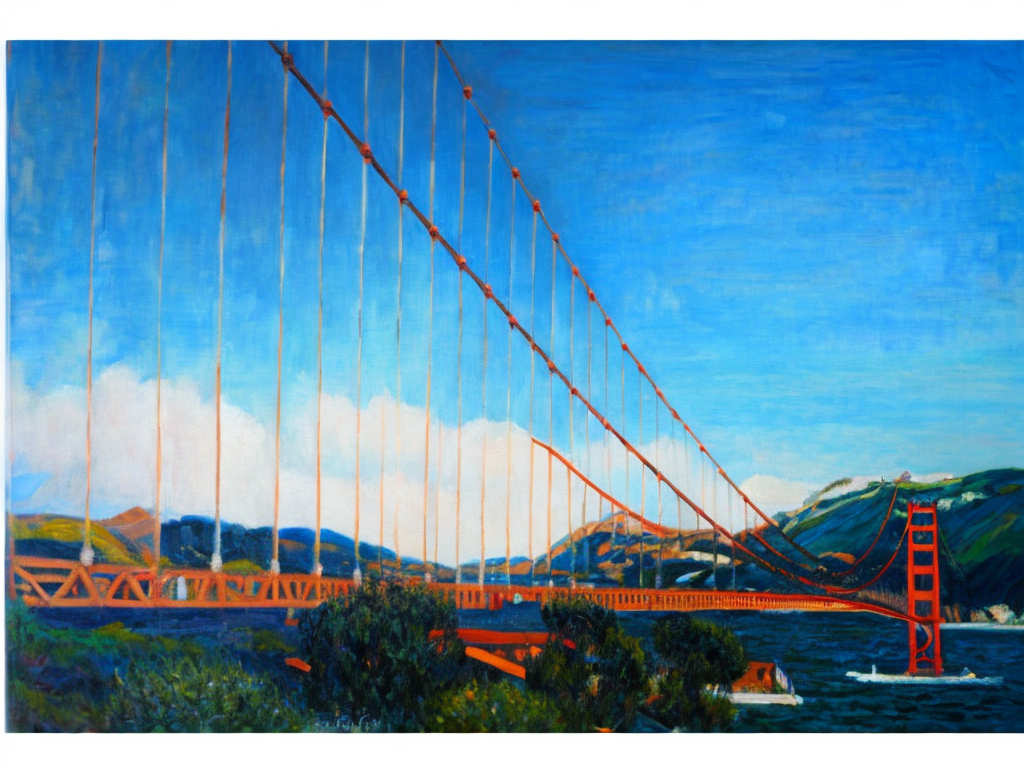

In [38]:
noise_scheduler = prepare_noise_scheduler(infer_scheduler, pipe_config['steps'], pipe_config['strength'])

# Convert the initial image to latent space
img_latents = pil_to_latent(sample_img, vae).to(unet.device).type(unet.dtype)

# Encode the prompt and negative prompt using the tokenizer and text_encoder
text_emb = text_to_emb(prompt=pipe_config['prompt'], 
                       tokenizer=tokenizer, 
                       text_encoder=text_encoder, 
                       negative_prompt=pipe_config['negative_prompt'])

# Specify number of images to generate
num_images = 1
all_images = []
generator_states = []

for i in range(num_images):

    # Generate latent noise
    noise = torch.randn(img_latents.shape, generator=generator, device=unet.device, dtype=unet.dtype)

    # Add noise to the image latents at the first timestep
    latents = noise_scheduler.add_noise(img_latents, noise, noise_scheduler.timesteps[[0]]).to(unet.device)

    denoised_latents = denoise_text2img(latents=latents,
                                        text_emb=text_emb,
                                        unet=unet,
                                        noise_scheduler=noise_scheduler,
                                        guidance_scale=pipe_config['guidance'])

    # Decode output tensors
    generator_states.append([int(i) for i in generator.get_state()])
    all_images.append(latent_to_pil(denoised_latents, vae))
    if device == 'cuda': torch.cuda.empty_cache()


for i, image in enumerate(all_images):
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]
    with open(f"{output_dir}/{img_hash}-{img_id}.json", "w") as write_file:
        json.dump(pipe_config, write_file)
    image.save(f"{output_dir}/{img_hash}-{img_id}.png", format='PNG')
    pipe_config['generator_state'] = generator_states[i]

stack_imgs(all_images)